# Comparing astroNN DR17 to other catalogues

In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, colors, cm
from scipy.stats import norm
from scipy.optimize import curve_fit

# File names
datafile = 'dr17_all_data.csv'
data_dir = '../src/data'

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Utility functions
def rms(array, axis=None):
    """
    Return the root-mean-square of a given array.

    Parameters
    ----------
    array : numpy.ndarray
    axis : int or None, optional
        Axis along which to calculate rms (passed to numpy.mean()).

    """
    return np.sqrt(np.mean(array**2, axis=axis))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    Parameters
    ----------
    arr1 : numpy.ndarray
    arr2 : numpy.ndarray

    """
    return np.sqrt(arr1**2 + arr2**2)

# Plotting functions
def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k'):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
        
    dx = xbins[1] - xbins[0]
    dy = ybins[1] - ybins[0]
    ax.set_xlim((xlim[0] - 2*dx, xlim[1] + 2*dx))
    ax.set_ylim((ylim[0] - 2*dy, ylim[1] + 2*dy))
    
    return ax

def plot_rms_err(ax, xerrs, yerrs, loc='upper left', label=''):
    """
    Calculate RMS error of given arrays and plot characteristic error bars.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
    xerrs : array-like
        Errors on horizontal coordinates. If xerrs is 2-dimensional, it is
        assumed to contain separate positive and negative errors.
    yerrs : array-like
    loc : str, optional
        Location to plot characteristic error bars. Options are 'upper left',
        'upper right', 'lower left', or 'lower right'. The default is 'upper left'.
    label : str, optional
        Plot label for error bars. The default is '', which does not generate a label.
        
    Returns
    -------
    matplotlib.axes.Axes
    
    """
    # Convert to numpy and drop NaN
    xerrs = np.array(xerrs)
    xerrs = xerrs[~np.isnan(xerrs)]
    yerrs = np.array(yerrs)
    yerrs = yerrs[~np.isnan(yerrs)]
    # Calculate RMS error
    if len(xerrs.shape) > 1:
        xerr = rms(xerrs, axis=0)[:,np.newaxis]
    else:
        xerr = np.array([rms(xerrs)])
    if len(yerrs.shape) > 1:
        yerr = rms(yerrs, axis=0)[:,np.newaxis]
    else:
        yerr = np.array([rms(yerrs)])
    
    # Set error bar location
    xlim = ax.get_xlim()
    xpad = 0.05 * (xlim[1] - xlim[0])
    ylim = ax.get_ylim()
    ypad = 0.05 * (ylim[1] - ylim[0])
    if type(loc) == tuple or type(loc) == list or type(loc) == np.ndarray:
        x, y = loc
    elif loc == 'upper right':
        x = xlim[1] - xpad - xerr[-1]
        y = ylim[1] - ypad - yerr[-1]
    elif loc == 'lower right':
        x = xlim[1] - xpad - xerr[-1]
        y = ylim[0] + ypad + yerr[0]
    elif loc == 'lower left':
        x = xlim[0] + xpad + xerr[0]
        y = ylim[0] + ypad + yerr[0]
    else:
        x = xlim[0] + xpad + xerr[0]
        y = ylim[1] - ypad - yerr[-1]
    
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, color='k', capsize=2, label=label, linestyle='none')
    
    return ax

In [8]:
# Import DR17 data and VACs
data = pd.read_csv(Path(data_dir) / datafile)
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656876,2M23595886-2009435,apo25m,060-75,none,359.995258,-20.162107,60.806239,-76.324013,11.788,0.022,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
656877,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
656878,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
656879,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


## Ages from APOKASC-2 and astroNN

A number of stars in the astroNN catalog have reported ages which differ greatly from the APOKASC-2 asteroseismic ages. Comparing the two ages here, it seems that a cut of (astroNN age - APOKASC age) < -5 Gyr distinguishes the truly discrepant ages from the intrinsic scatter about 0. Most of these stars have ages > 10 Gyr in the APOKASC catalog. According to Mackereth+ 2019, the neural net relies heavily on C and N bands, and its accuracy breaks down above 10 Gyr. In their Figure A1, they show that astroNN severly underestimates ages above 10 Gyr, and also slightly overestimates ages for the youngest stars. On the other hand, the highest asteroseismic ages are unphysically old, so it's possible that astroNN is more correct. Interestingly, the distribution of age differences can be fit by a tri-modal Gaussian, with the first two modes centered around 0 and the third describing most of the outliers centered around -7.5 Gyr.

In [3]:
def get_discrepant_ages(cat, diff_cut=-5):
    """
    Identify targets where the astroNN reported age differs substantially
    from APOKASC-2.

    Parameters
    ----------
    cat : pandas.DataFrame
        Combined catalog of at least APOKASC-2 and astroNN DR17
    diff_cut : float, optional
        Age difference in Gyr between catalogs defined as discrepant.
        The default is -5.
    
    Returns
    -------
    pandas.DataFrame, pandas.DataFrame
        The first DataFrame selects only targets with ages from both catalogs,
        the second selects targets with the most discrepant ages.

    """
    # Select targets with ages from both APOKASC and astroNN
    ages = cat[(pd.notna(cat['APOKASC2_AGE'])) &
               (pd.notna(cat['APOKASC2_AGE_PERR'])) &
               (pd.notna(cat['ASTRONN_AGE'])) &
               (pd.notna(cat['ASTRONN_AGE_ERR']))].copy()
    ages['AGE_DIFF'] = ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']
    ages['AGE_DIFF_MERR'] = quad_add(ages['ASTRONN_AGE_ERR'],
                                     ages['APOKASC2_AGE_MERR'])
    ages['AGE_DIFF_PERR'] = quad_add(ages['ASTRONN_AGE_ERR'],
                                     ages['APOKASC2_AGE_PERR'])
    low_age = ages[ages['AGE_DIFF'] < diff_cut].copy()
    return ages, low_age

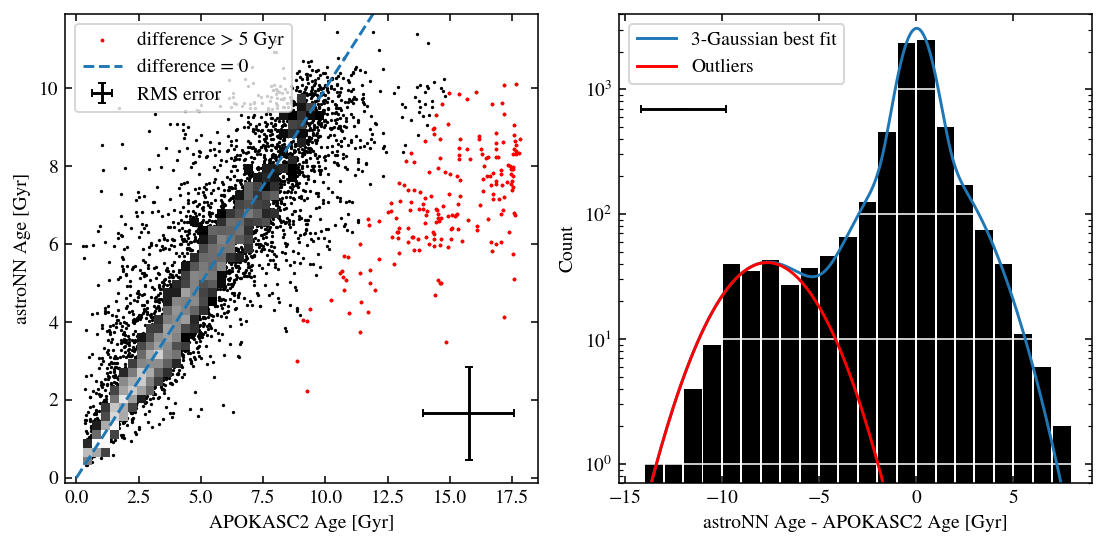

In [4]:
ages, low_age = get_discrepant_ages(data, diff_cut=-5)

# APOKASC age vs astroNN age
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

ax = axs[0]
scatter_hist(ax, ages['APOKASC2_AGE'], ages['ASTRONN_AGE'])
ax.scatter(low_age['APOKASC2_AGE'], low_age['ASTRONN_AGE'], c='r', s=1, label='difference > 5 Gyr')
plot_rms_err(ax, ages[['APOKASC2_AGE_MERR', 'APOKASC2_AGE_PERR']], ages['ASTRONN_AGE_ERR'], loc='lower right', label='RMS error')
ax.plot([0, 12], [0, 12], linestyle='--', label='difference = 0')
ax.legend(loc='upper left')
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN Age [Gyr]')

# Histrogram of age differences
ax = axs[1]
xmin = -14
xmax = 8
bins = np.linspace(xmin, xmax, xmax-xmin+1)
y, x, _ = ax.hist(ages['AGE_DIFF'], color='k', bins=bins, rwidth=0.9)
ax.grid(which='major', axis='y', color='w')
plot_rms_err(ax, ages[['AGE_DIFF_MERR', 'AGE_DIFF_PERR']], [0], loc=(-12, 700))

def trimodal_norm(x, loc1, scale1, a1, loc2, scale2, a2, loc3, scale3, a3):
    """Trimodal Gaussian to fit to age difference."""
    return a1 * norm.pdf(x, loc1, scale1) + a2 * norm.pdf(x, loc2, scale2) + a3 * norm.pdf(x, loc3, scale3)

# best fit trimodal normal
x = x[:-1] + (x[1] - x[0])/2
params, cov = curve_fit(trimodal_norm, x, y, p0=(0, 0.5, 5e3, 0, 2, 1e3, -9, 2, 40))
x_fine = np.arange(xmin, xmax, 0.1)
ax.plot(x_fine, trimodal_norm(x_fine, *params), label='3-Gaussian best fit')
# individual distributions
ax.plot(x_fine, params[8] * norm.pdf(x_fine, *params[6:8]), c='r', label='Outliers')
# plot settings
ax.set_yscale('log')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('Count')
ax.set_ylim((7e-1, 4e3))
ax.legend()

plt.show()

In [5]:
print(ages.shape[0])
print(low_age.shape[0])

6519
197


### APOGEE signal-to-noise

This isn't just an issue with low S/N targets, as the stars with age discrepancies don't seem to have a significantly lower S/N in ASPCAP than the general population of APOKASC-2 targets.

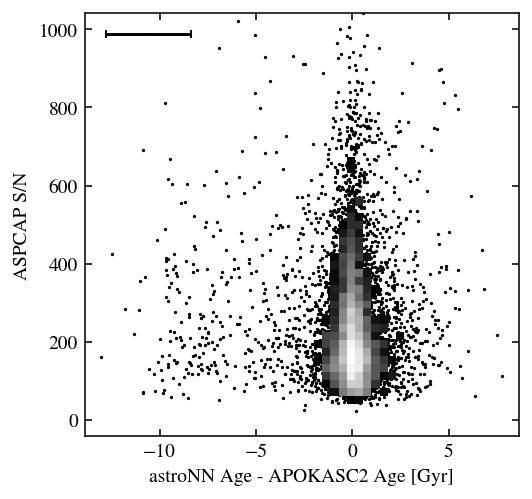

In [6]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['AGE_DIFF'], ages['SNREV'], ylim=(0, 1000))
plot_rms_err(ax, ages[['AGE_DIFF_MERR', 'AGE_DIFF_PERR']], [0])
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('ASPCAP S/N')
plt.show()

### Data flags

There doesn't appear to be one particular flag which is over-represented in the age-discrepant sample, so this is probably not an issue with data quality.

In [7]:
def count_flags(cat, flag_type):
    """
    Count the number of times each flag is raised in the DataFrame.
    
    """
    # Choose flag column
    if 'targ' in flag_type.lower():
        flag_col = 'TARGFLAGS'
    elif 'aspcap' in flag_type.lower():
        flag_col = 'ASPCAPFLAGS'
    else:
        return {}
    
    cat = cat.copy()
    # List of all unique flags
    flags = list(dict.fromkeys(','.join(cat[flag_col].to_list()).split(',')))
    flags_count = {}
    # Count occurrences of each flag
    for f in flags:
        is_flag = cat[flag_col].str.contains(f)
        flags_count[f] = is_flag.value_counts()[True]
    return flags_count

aspcap_flags = pd.DataFrame.from_dict(count_flags(ages, 'aspcap'), orient='index', columns=['ALL'])
aspcap_flags = aspcap_flags.join(pd.DataFrame.from_dict(count_flags(low_age, 'aspcap'), 
                                                        orient='index', columns=['LOW_AGE']))
aspcap_flags = aspcap_flags.fillna(0).astype(int)
print(aspcap_flags)

target_flags = pd.DataFrame.from_dict(count_flags(ages, 'target'), orient='index', columns=['ALL'])
target_flags = target_flags.join(pd.DataFrame.from_dict(count_flags(low_age, 'target'), 
                                                  orient='index', columns=['LOW_AGE']))
target_flags = target_flags.fillna(0).astype(int)
print(target_flags)

                   ALL  LOW_AGE
none              6050      180
VMICRO_WARN        234        5
N_M_WARN            70        4
VSINI_WARN          36        0
TEFF_WARN           25        4
STAR_WARN          140       10
STAR_BAD            20        0
NO_ASPCAP_RESULT    12        0
NO_GRID             12        0
BAD_FRAC_BADPIX     12        0
LOGG_BAD             7        0
COLORTE_WARN       113        6
LOGG_WARN            3        0
C_M_WARN             1        0
SN_BAD               2        0
ROTATION_WARN        2        0
MULTIPLE_SUSPECT     1        0
M_H_WARN             1        0
                                            ALL  LOW_AGE
APOGEE_ANCILLARY                           2937       79
APOGEE_KEPLER_SEISMO                       6063      161
APOGEE_KEPLER_COOLDWARF                      58        8
APOGEE_KEPLER_HOST                            3        0
APOGEE_WISE_DERED                            43        6
APOGEE_SHORT                                101   

### Stellar parameters from ASPCAP and astroNN

For stars with APOKASC-2 ages (i.e., red giants), astroNN agrees well with parameters determined by ASPCAP. This good agreement does not go away when looking at the stars with age discrepancies. The age-discrepant targets seem to have a similar distribution of abundances to the full sample. However, the age-discrepant stars do have significantly lower $T_{\rm{eff}}$ and $\log(g)$ values than the full sample.

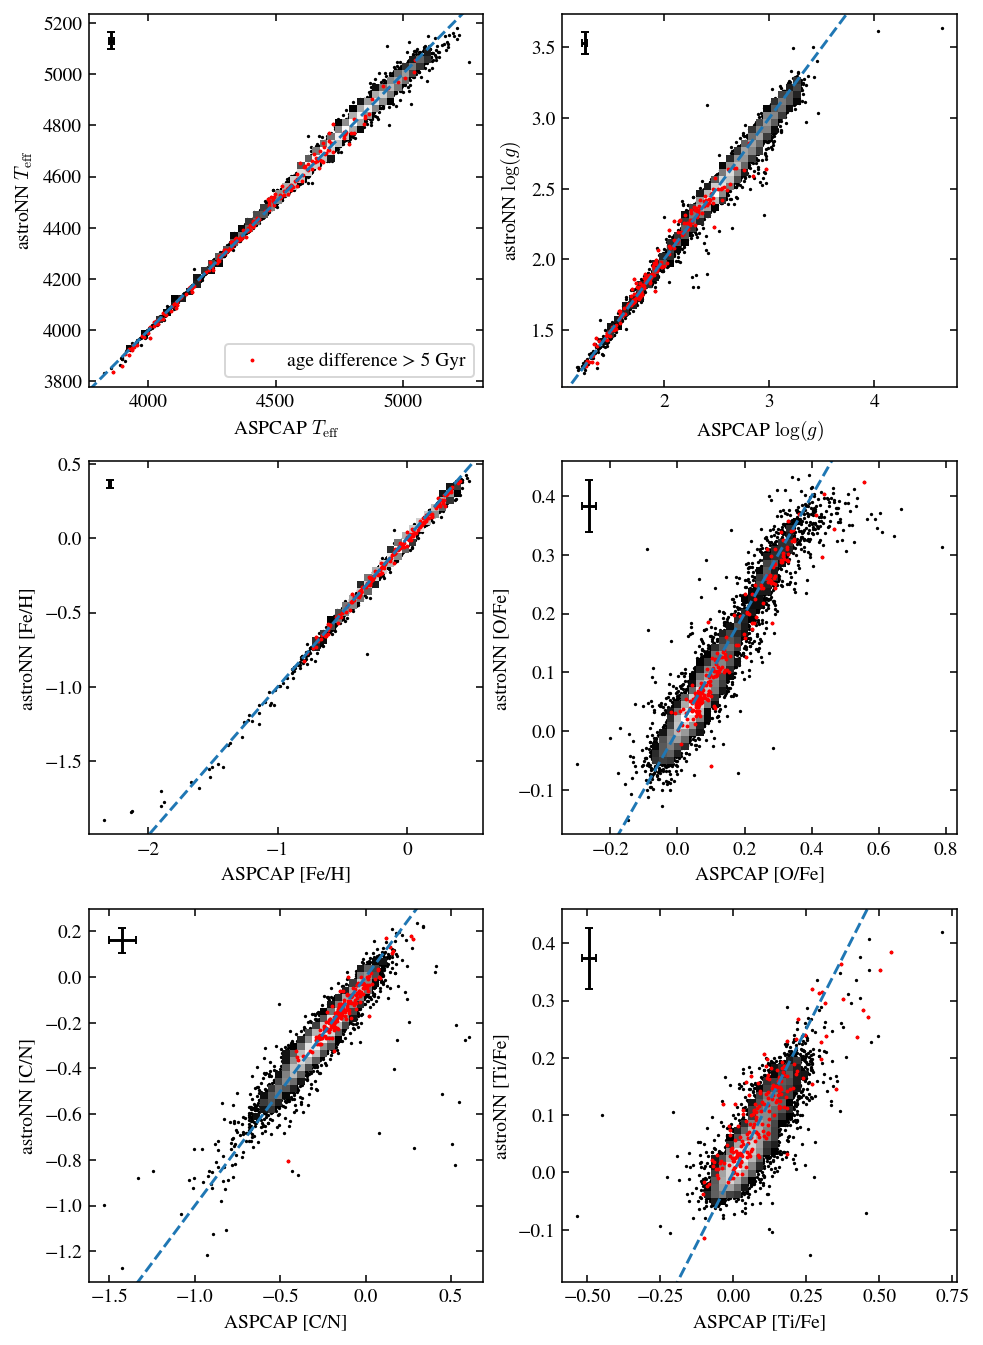

In [8]:
def compare_aspcap_astronn(ax, col1, col2, errloc='upper left', 
                           outlier_label=None, legend_loc='best', axlabel=''):
    # Compare the same quantity from ASPCAP and astroNN
    scatter_hist(ax, ages[col1], ages[col2])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, xlim, linestyle='--')
    ax.scatter(low_age[col1], low_age[col2], c='r', s=1, label=outlier_label)
    errcol1 = col1 + '_ERR'
    errcol2 = col2 + '_ERR'
    plot_rms_err(ax, ages[errcol1].dropna(), ages[errcol2].dropna(), loc=errloc)
    if len(axlabel) > 0:
        ax.set_xlabel('ASPCAP ' + axlabel)
        ax.set_ylabel('astroNN ' + axlabel)
    else:
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
    if outlier_label != None:
        ax.legend(loc=legend_loc)

fig, axs = plt.subplots(3, 2, figsize=(8, 12))
ax = axs[0,0]
compare_aspcap_astronn(ax, 'TEFF', 'ASTRONN_TEFF', axlabel=r'$T_{\rm{eff}}$', outlier_label='age difference > 5 Gyr')
ax = axs[0,1]
compare_aspcap_astronn(ax, 'LOGG', 'ASTRONN_LOGG', axlabel=r'$\log(g)$')
ax = axs[1,0]
compare_aspcap_astronn(ax, 'M_H', 'ASTRONN_FE_H', axlabel='[Fe/H]')
ax = axs[1,1]
compare_aspcap_astronn(ax, 'O_FE', 'ASTRONN_O_FE', axlabel='[O/Fe]')
ax = axs[2,0]
compare_aspcap_astronn(ax, 'C_N', 'ASTRONN_C_N', axlabel='[C/N]')
ax = axs[2,1]
compare_aspcap_astronn(ax, 'TI_FE', 'ASTRONN_TI_FE', axlabel='[Ti/Fe]')
plt.show()

Looking at age vs $\log(g)$ from APOKASC-2, it's interesting that there are almost no stars with $\log(g)>2.5$ and age > 10 Gyr. There are a decent number of stars below $\log(g)\approx2.5$ and older than 10 Gyr, but most of them are discrepant with astroNN ages.

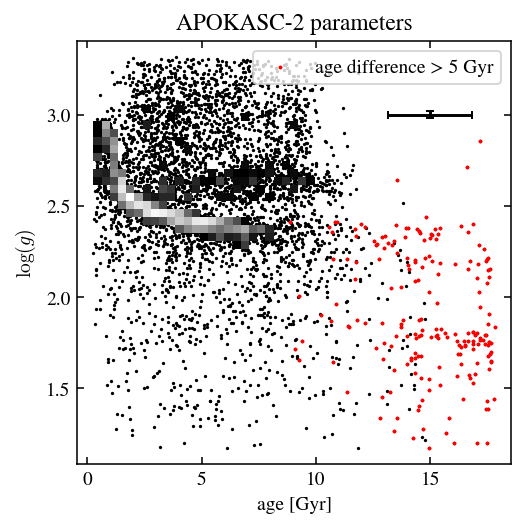

In [9]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['APOKASC2_AGE'], ages['APOKASC2_LOGG'])
ax.scatter(low_age['APOKASC2_AGE'], low_age['APOKASC2_LOGG'], c='r', s=1, label='age difference > 5 Gyr')
plot_rms_err(ax, ages[['APOKASC2_AGE_MERR', 'APOKASC2_AGE_PERR']], ages['APOKASC2_LOGG_RANERR'], loc=(15, 3))
ax.legend(loc='upper right')
ax.set_xlabel('age [Gyr]')
ax.set_ylabel(r'$\log(g)$')
ax.set_title('APOKASC-2 parameters')
plt.show()

Here is where the age-discrepant stars lie in relation to the $\alpha$-Fe diagram for the APOKASC-2 sample. They seem to follow the same general bimodal distribution.

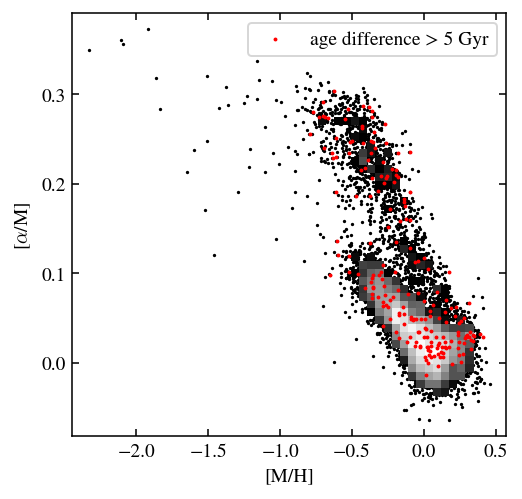

In [10]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['FE_H'], ages['ALPHA_M'])#, xlim=(-1, 0.5))
ax.scatter(low_age['M_H'], low_age['ALPHA_M'], c='r', s=1, label='age difference > 5 Gyr')
ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[$\alpha$/M]')
ax.legend()
plt.show()

Here is a comparison of the distributions of all stars with APOKASC-2 ages and those with discrepant ages in (ASPCAP) metallicity and alpha-abundance space. The blue histogram traces 3% of the total, which is where we would expect to see the red histogram if age discrepancy was independent of metallicity. On the left plot, we see that low-[M/H] stars may be slightly more common than we expect. On the right plot, the high-$\alpha$ stars seem to be over-represented in the discrepant set compared to the total.

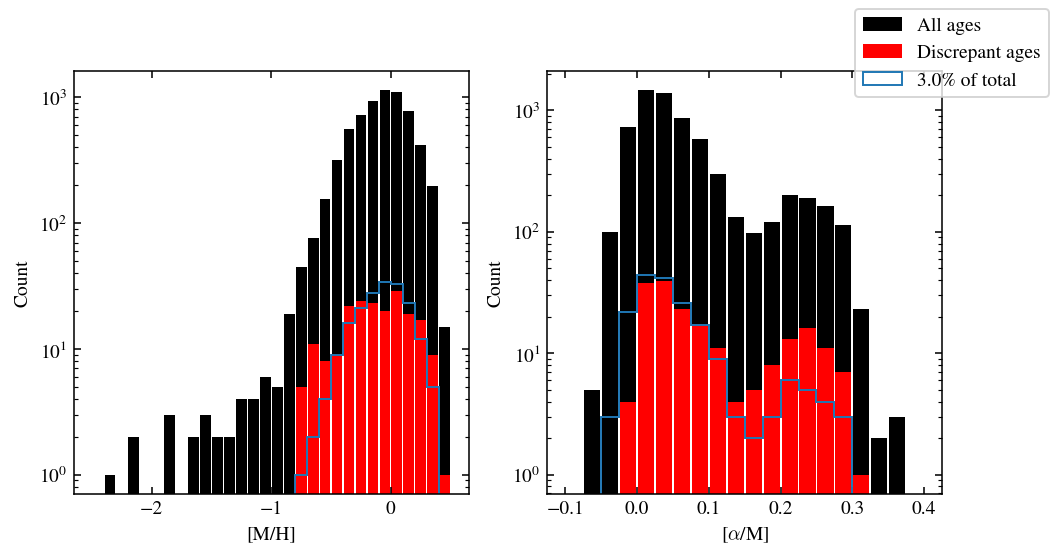

In [11]:
low_age_frac = low_age.shape[0] / ages.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
mbins = np.linspace(-2.5, 0.5, 31)
hist = ax.hist(ages['M_H'], color='k', rwidth=0.9, bins=mbins, label='All ages')
ax.hist(low_age['M_H'], color='r', rwidth=0.9, bins=mbins, label='Discrepant ages')
ax.hist(hist[1][:-1], weights=np.floor(low_age_frac*hist[0]), bins=mbins, histtype='step', 
        label=f'{100*low_age_frac:.01f}% of total')
ax.set_yscale('log')
ax.set_xlabel('[M/H]')
ax.set_ylabel('Count')

ax = axs[1]
abins = np.linspace(-0.1, 0.4, 21)
hist = ax.hist(ages['ALPHA_M'], color='k', rwidth=0.9, bins=abins)
ax.hist(low_age['ALPHA_M'], color='r', rwidth=0.9, bins=abins)
ax.hist(hist[1][:-1], weights=np.floor(low_age_frac*hist[0]), bins=abins, histtype='step')
ax.set_yscale('log')
ax.set_xlabel(r'[$\alpha$/M]')
ax.set_ylabel('Count')

fig.legend()
plt.show()

### *Gaia* Distances and Photometry

In both the *Gaia* CMD and the APOKASC-2 $\log(g)$-$T_{\rm{eff}}$ space, age-discrepant stars seem to mostly lie along the upper RGB rather than on the red clump.

In [12]:
def get_gaia_cmd(data):
    """
    Calculate Gaia colors and absolute magnitudes based on 
    geo-photometric distance and including a reddening correction.
    
    """
    cmd = data.copy()
    cmd['GAIAEDR3_DIST_MOD'] = 5*np.log10(cmd['GAIAEDR3_R_MED_PHOTOGEO']) - 5
    # Absolute Gaia G-band magnitude
    cmd['GAIAEDR3_ABS_MAG'] = cmd['GAIAEDR3_PHOT_G_MEAN_MAG'] - cmd['GAIAEDR3_DIST_MOD']
    # Gaia BP - RP color
    cmd['GAIAEDR3_COLOR'] = cmd['GAIAEDR3_PHOT_BP_MEAN_MAG'] - cmd['GAIAEDR3_PHOT_RP_MEAN_MAG']
    # Correct for reddening
    cmd['GAIAEDR3_COLOR'] -= cmd['SFD_EBV']
    return cmd

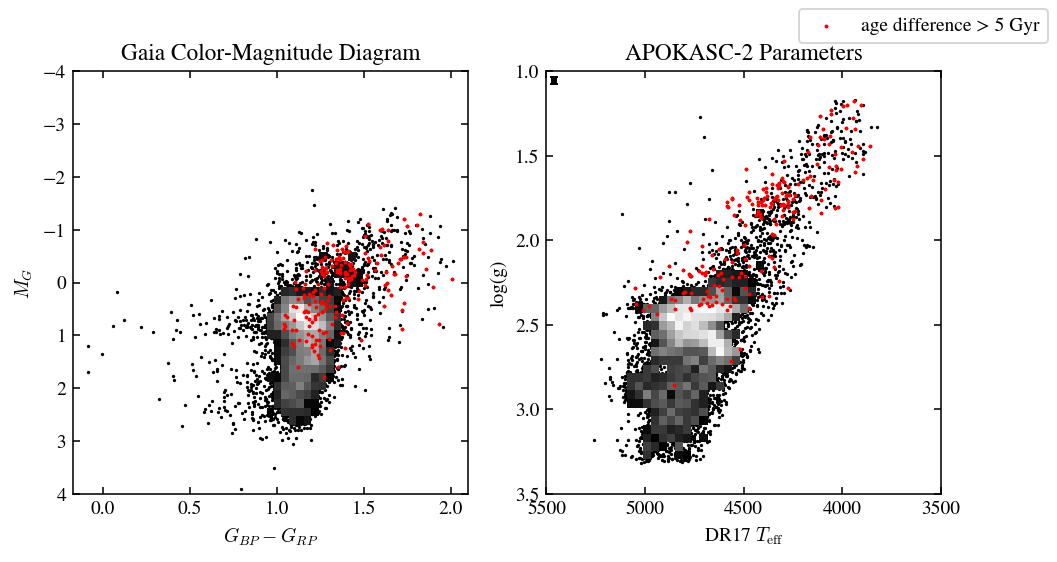

In [13]:
cmd = get_gaia_cmd(data)
cmd_ages, cmd_low_age = get_discrepant_ages(cmd, diff_cut=-5)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Gaia CMD
ax = axs[0]
scatter_hist(ax, cmd_ages['GAIAEDR3_COLOR'], cmd_ages['GAIAEDR3_ABS_MAG'], ylim=(-4, 4))
ax.scatter(cmd_low_age['GAIAEDR3_COLOR'], cmd_low_age['GAIAEDR3_ABS_MAG'], 
           c='r', s=1, label='age difference > 5 Gyr')
ax.set_ylim((4, -4))
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
ax.set_title('Gaia Color-Magnitude Diagram')

# APOKASC-2 log(g) vs Teff
ax = axs[1]
scatter_hist(ax, ages['TEFF'], ages['APOKASC2_LOGG'], 
             xlim=(3500, 5500), ylim=(1, 3.5))
ax.scatter(low_age['TEFF'], low_age['APOKASC2_LOGG'], c='r', s=1)
plot_rms_err(ax, ages['TEFF_ERR'], ages[['APOKASC2_LOGG_RANERR', 'APOKASC2_LOGG_SYSERR']], loc='lower right')
ax.set_xlim((5500, 3500))
ax.set_ylim((3.5, 1))
ax.set_xlabel(r'DR17 $T_{\rm{eff}}$')
ax.set_ylabel('log(g)')
ax.set_title('APOKASC-2 Parameters')

fig.legend()
plt.show()

Similar to the above abundance distributions but for distances based on Gaia parallax. I've just done a simple conversion from Gaia parallax to distance and haven't done any error propagation yet. Here it seems like stars with discrepant ages are far more likely (up to 10 times) to be at farther distances compared to the total set, and less likely to be within 2 kpc.

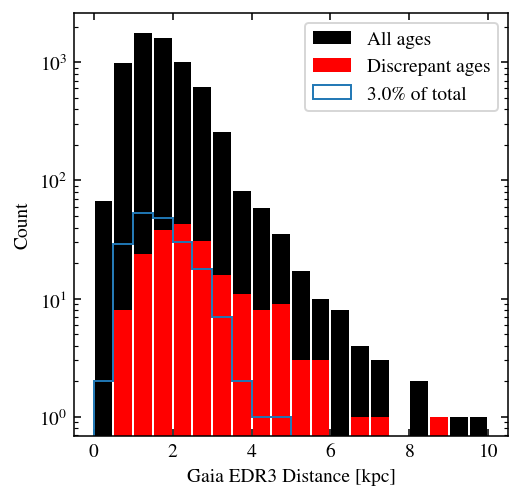

In [14]:
fig, ax = plt.subplots()
bins = np.linspace(0, 10, 21)
hist = ax.hist(cmd_ages['GAIAEDR3_R_MED_PHOTOGEO']/1000, 
               color='k', rwidth=0.9, bins=bins, label='All ages')
ax.hist(cmd_low_age['GAIAEDR3_R_MED_PHOTOGEO']/1000, 
        color='r', rwidth=0.9, bins=bins, label='Discrepant ages')
ax.hist(hist[1][:-1], weights=np.floor(low_age_frac*hist[0]), 
        bins=bins, histtype='step',
        label=f'{100*low_age_frac:.01f}% of total')
ax.set_yscale('log')
ax.set_xlabel('Gaia EDR3 Distance [kpc]')
ax.set_ylabel('Count')
ax.legend()
plt.show()

### Radial Velocity Scatter

There appears to be no difference in the magnitude of RV scatter between stars with discrepant ages and stars with good age agreement.

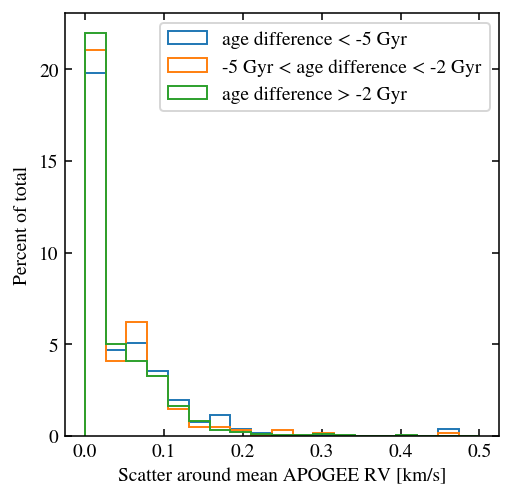

In [15]:
fig, ax = plt.subplots()
bins = np.linspace(0, 0.5, 20)
ax.hist(low_age['VSCATTER'], density=True, bins=bins, histtype='step', label='age difference < -5 Gyr')
good_age = ages[(ages['AGE_DIFF'] > -5) & (ages['AGE_DIFF'] < -2)]
ax.hist(good_age['VSCATTER'], density=True, bins=bins, histtype='step', label='-5 Gyr < age difference < -2 Gyr')
best_age = ages[np.abs(ages['AGE_DIFF']) < 2]
ax.hist(best_age['VSCATTER'], density=True, bins=bins, histtype='step', label='age difference > -2 Gyr')
ax.set_xlabel('Scatter around mean APOGEE RV [km/s]')
ax.set_ylabel('Percent of total')
plt.legend()
plt.show()

### Conclusions about age discrepancies

A small subset of APOKASC-2 stars are given ages which differ substantially (>5 Gyr older) from those determined by astroNN. We think this discrepancy is mostly the result of mass loss, as APOKASC draws from parameters (mass, density, etc) which would be altered due to mass loss, while astroNN does not. We take the astroNN ages as likely closer to truth.

## Metallicities from ASPCAP (DR17), StarHorse, and astroNN

As the left panels of this plot show, there is a large group of stars for which astroNN significantly underestimates the metallicity with respect to both ASPCAP (top) and StarHorse (bottom). The top right panel shows that astroNN also gets slightly higher [Fe/H] for the lowest metallicity ([Fe/H] < -2) stars as compared to ASPCAP. The bottom left panel shows that StarHorse doesn't have the same problem as astroNN, but it does produce systematically slightly higher [Fe/H] for the lower-metallicity stars.

In [9]:
def get_discrepant_metallicities(data, diff_cut=-0.5, fe_min=-4, fe_max=1):
    """
    Identify targets where the astroNN reported [Fe/H] differs substantially
    from ASPCAP.
    
    Parameters
    ----------
    data : pandas.DataFrame
        Combined catalogue of APOGEE parameters and VACs.
    diff_cut : float, optional
        Metallicity difference between astroNN and APOGEE defined
        as discrepant. The default is -0.5 dex.
    fe_min : float, optional
        Minimum allowed value of [Fe/H]; lower values will be cut.
        The default is -4 dex.
    fe_max : float, optional
        Maximum allowed [Fe/H]; higher values will be cut.
        The default is +1 dex.
        
    Returns
    -------
    pandas.DataFrame, pandas.DataFrame
        The first DataFrame selects only targets with [Fe/H] from both catalogs,
        the second selects targets with the most discrepant metallicities.

    """
    # Select targets with metallicities from both ASPCAP and astroNN
    metals = data[(pd.notna(data['ASTRONN_FE_H'])) &
                  (pd.notna(data['ASTRONN_FE_H_ERR'])) &
                  (pd.notna(data['M_H'])) &
                  (pd.notna(data['M_H_ERR']))].copy()
    # Limit astroNN metallicities and errors to a reasonable range
    metals = metals[(metals['ASTRONN_FE_H'] < fe_max) &
                    (metals['ASTRONN_FE_H'] > fe_min) & 
                    (metals['ASTRONN_FE_H_ERR'] < (fe_max - fe_min)/2)]
    metals['M_H_DIFF'] = metals['ASTRONN_FE_H'] - metals['M_H']
    metals['M_H_DIFF_ERR'] = quad_add(metals['ASTRONN_FE_H_ERR'],
                                      metals['M_H_ERR'])
    low_fe = metals[metals['M_H_DIFF'] < diff_cut].copy()
    return metals, low_fe

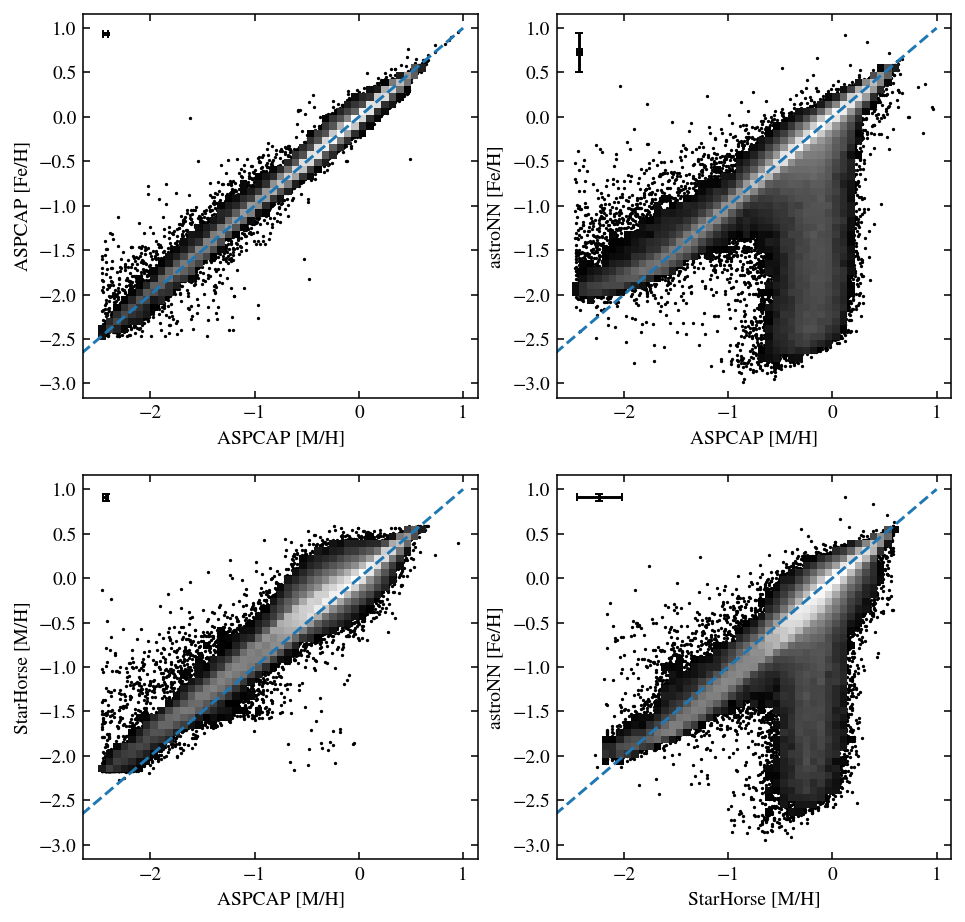

In [10]:
metals, low_fe = get_discrepant_metallicities(data, diff_cut=-0.5)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
line = [-3, 1]
xlim = (-2.5, 1)
ylim = (-3, 1)

ax = axs[0,0]
scatter_hist(ax, metals['M_H'], metals['FE_H'], xlim=xlim, ylim=ylim)
ax.plot(line, line, linestyle='--')
plot_rms_err(ax, metals['M_H_ERR'], metals['FE_H_ERR'])
ax.set_xlabel('ASPCAP [M/H]')
ax.set_ylabel('ASPCAP [Fe/H]')

ax = axs[0,1]
scatter_hist(ax, metals['M_H'], metals['ASTRONN_FE_H'], xlim=xlim, ylim=ylim)
ax.plot(line, line, linestyle='--')
plot_rms_err(ax, metals['M_H_ERR'], metals['ASTRONN_FE_H_ERR'])
ax.set_xlabel('ASPCAP [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

ax = axs[1,0]
scatter_hist(ax, metals['M_H'], metals['STARHORSE_MET'], xlim=xlim, ylim=ylim)
# ax.scatter(low_fe['M_H'], low_fe['STARHORSE_MET'], s=1, c='b')
ax.plot(line, line, linestyle='--')
plot_rms_err(ax, metals['M_H_ERR'], metals[['STARHORSE_MET_MERR', 'STARHORSE_MET_PERR']])
ax.set_xlabel('ASPCAP [M/H]')
ax.set_ylabel('StarHorse [M/H]')

ax = axs[1,1]
scatter_hist(ax, metals['STARHORSE_MET'], metals['ASTRONN_FE_H'], xlim=xlim, ylim=ylim)
ax.plot(line, line, linestyle='--')
plot_rms_err(ax, metals['ASTRONN_FE_H_ERR'], metals[['STARHORSE_MET_MERR', 'STARHORSE_MET_PERR']])
ax.set_xlabel('StarHorse [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

plt.show()

### ASPCAP Signal-to-Noise

The median S/N reported by ASPCAP is a bit lower for the discrepant targets, but still over 100.

Median S/N for low-astroNN [Fe/H] targets: 102.825115
Median S/N for all targets: 141.88086


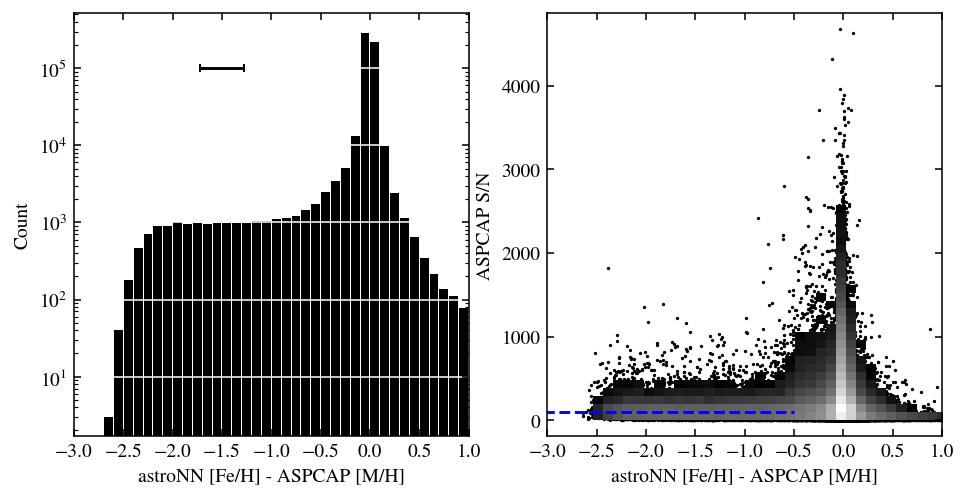

In [11]:
print('Median S/N for low-astroNN [Fe/H] targets:', np.median(low_fe['SNREV']))
print('Median S/N for all targets:', np.median(metals['SNREV']))

fig, axs = plt.subplots(1,2, figsize=(8, 4), sharex=True)

ax = axs[0]
xmin = -3
xmax = 1
xstep = 0.1
bins = np.arange(xmin, xmax+xstep, xstep)
y, x, _ = ax.hist(metals['M_H_DIFF'], color='k', bins=bins, rwidth=0.9)
ax.errorbar(-1.5, 1e5, xerr=rms(metals['M_H_DIFF_ERR']), c='k', capsize=2)
ax.grid(which='major', axis='y', color='w')
ax.set_yscale('log')
ax.set_xlabel('astroNN [Fe/H] - ASPCAP [M/H]')
ax.set_ylabel('Count')
ax.set_xticks(np.arange(xmin, xmax+0.5, 0.5))
ax.set_xlim((xmin, xmax))

ax = axs[1]
scatter_hist(ax, metals['M_H_DIFF'], metals['SNREV'])
ax.plot([-3.2, -0.5], [np.median(low_fe['SNREV']), np.median(low_fe['SNREV'])], 
        linestyle='--', color='b')
ax.set_xlabel('astroNN [Fe/H] - ASPCAP [M/H]')
ax.set_ylabel('ASPCAP S/N')
ax.set_xlim((xmin, xmax))
plt.show()

### Other Stellar Parameters

Most of the stars with discrepant metallicities are concentrated on the lower end of the effective temperature range and the higher end of the surface gravity range. They mostly lie along the centerline of the [O/Fe] distribution and are largely absent from the [C/N] distribution entirely. Comparisons of the latter two parameters between astroNN and ASPCAP (bottom row) may be interesting in their own right, but they probably aren't relevant for the [Fe/H] discussion.

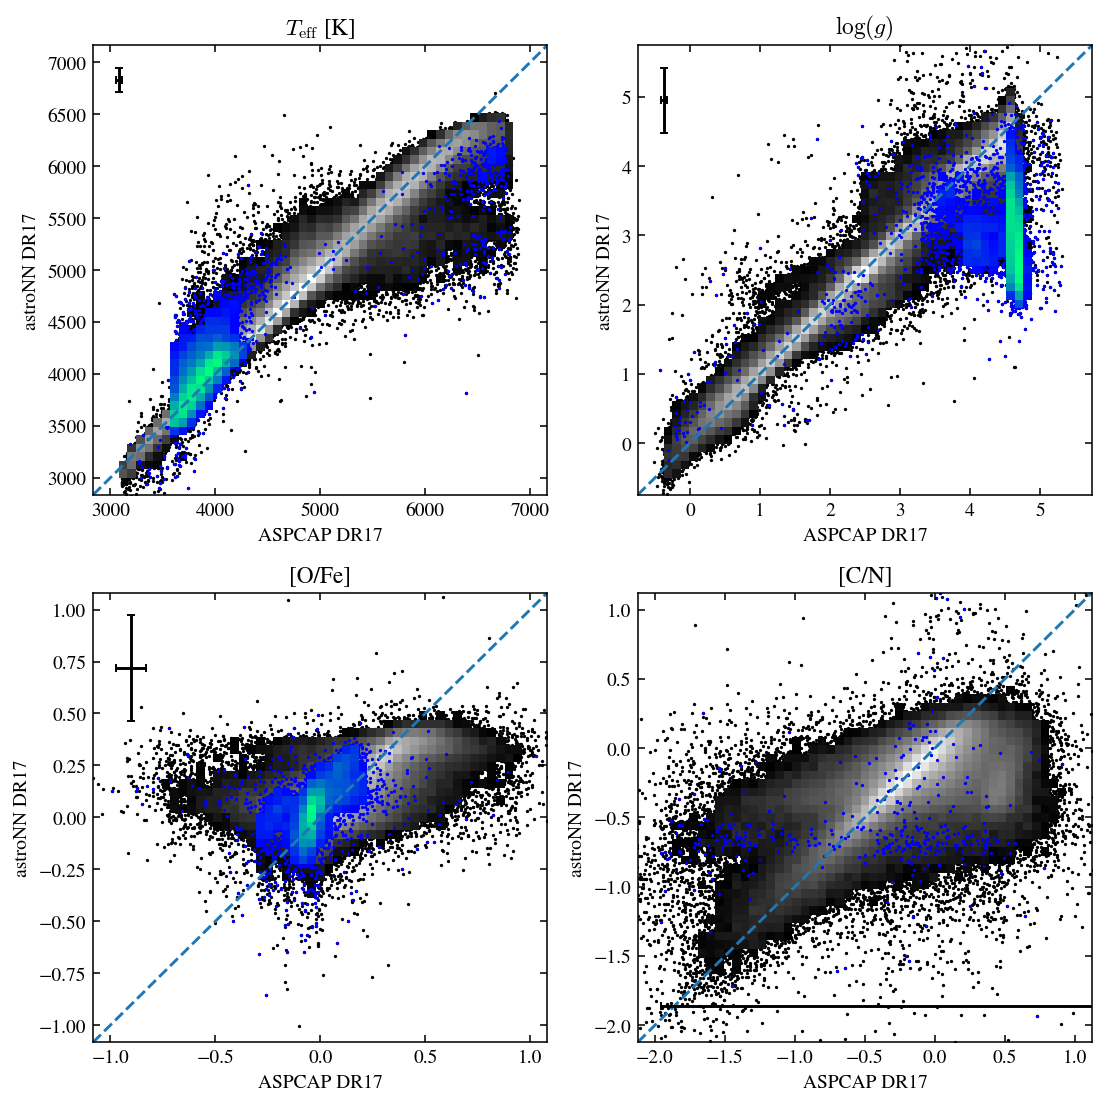

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

xcols = ['TEFF', 'LOGG', 'O_FE', 'C_N']
ycols = ['ASTRONN_TEFF', 'ASTRONN_LOGG', 'ASTRONN_O_FE', 'ASTRONN_C_N']
axlabels = [r'$T_{\rm{eff}}$ [K]', r'$\log(g)$', '[O/Fe]', '[C/N]']
axlims = [(3000, 7000), (-0.5, 5.5), (-1, 1), (-2, 1)]

for i, ax in enumerate(axs.flatten()):
    ax.set_title(axlabels[i])
    scatter_hist(ax, metals[xcols[i]], metals[ycols[i]], 
                 xlim=axlims[i], ylim=axlims[i])
    scatter_hist(ax, low_fe[xcols[i]], low_fe[ycols[i]], 
                 xlim=axlims[i], ylim=axlims[i],
                 cmap='winter', color='b')
#     ax.scatter(low_fe[xcols[i]], low_fe[ycols[i]], s=1, c='b')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, xlim, linestyle='--')
    plot_rms_err(ax, metals[xcols[i] + '_ERR'], metals[ycols[i] + '_ERR'], loc='upper left')
    ax.set_xlabel('ASPCAP DR17')
    ax.set_ylabel('astroNN DR17')
    
plt.show()

### Age

There is a strong correlation between astroNN's estimated age and metallicity for the low-[Fe/H] sample. This correlation is not a trend we see in the full sample, nor when looking at the ASPCAP metallicities. The affected stars mostly seem to be between 4 - 10 Gyr in age according to astroNN. Reassuringly, the distribution of the full sample (without the discrepant metallicities) seems qualitatively similar between astroNN and ASPCAP.

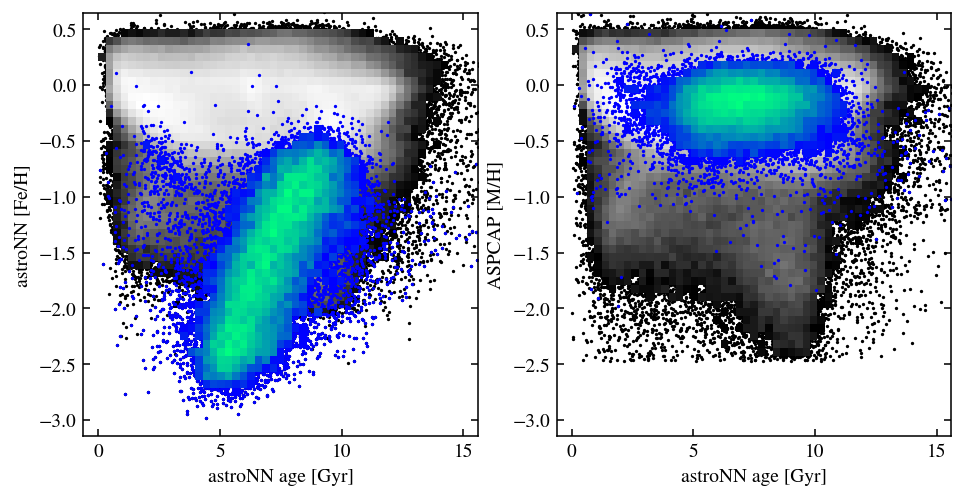

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
scatter_hist(ax, metals['ASTRONN_AGE'], metals['ASTRONN_FE_H'], xlim=(0, 15), ylim=(-3, 0.5))
scatter_hist(ax, low_fe['ASTRONN_AGE'], low_fe['ASTRONN_FE_H'], xlim=(0, 15), ylim=(-3, 0.5),
             cmap='winter', color='b')
ax.set_xlabel('astroNN age [Gyr]')
ax.set_ylabel('astroNN [Fe/H]')

ax = axs[1]
scatter_hist(ax, metals['ASTRONN_AGE'], metals['M_H'], xlim=(0, 15), ylim=(-3, 0.5))
scatter_hist(ax, low_fe['ASTRONN_AGE'], low_fe['M_H'], xlim=(0, 15), ylim=(-3, 0.5),
             cmap='winter', color='b')
ax.set_xlabel('astroNN age [Gyr]')
ax.set_ylabel('ASPCAP [M/H]')

plt.show()

### HR Diagrams

Plotting the stars with discrepant metallicites (blue) alongside the full sample (black) on the *Gaia* (EDR3) color-magnitude diagram shows the overwhelming majority of these stars are lower-main sequence dwarfs, plus a handful of blue stragglers.

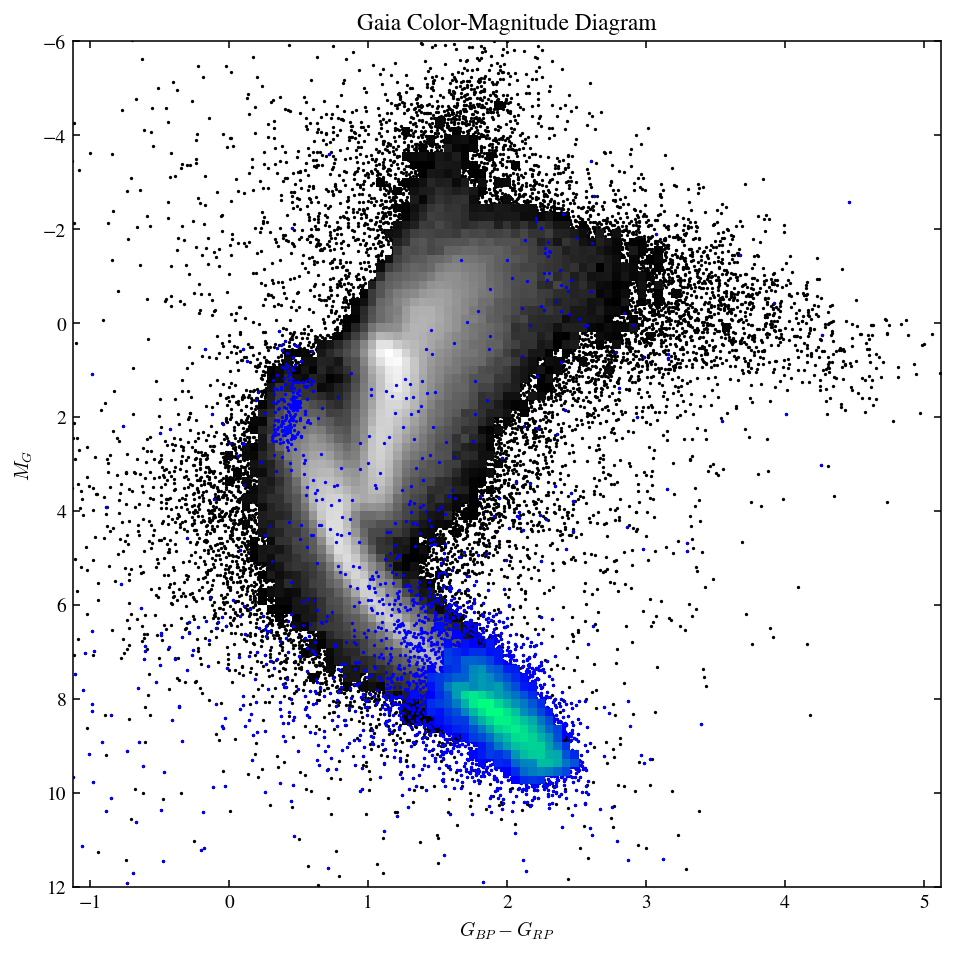

In [20]:
cmd = get_gaia_cmd(data)
cmd_metals, cmd_low_fe = get_discrepant_metallicities(cmd, diff_cut=-0.5)

fig, ax = plt.subplots(figsize=(8, 8))

xlim = (-1, 5)
ymin, ymax = (-6, 12)
scatter_hist(ax, cmd_metals['GAIAEDR3_COLOR'], cmd_metals['GAIAEDR3_ABS_MAG'], 
             ylim=(ymin, ymax), xlim=xlim, nbins=100)
# ax.scatter(cmd_low_fe['GAIAEDR3_COLOR'], cmd_low_fe['GAIAEDR3_ABS_MAG'], 
#            c='b', s=1, label='age difference > 5 Gyr')
scatter_hist(ax, cmd_low_fe['GAIAEDR3_COLOR'], cmd_low_fe['GAIAEDR3_ABS_MAG'],
             ylim=(ymin, ymax), xlim=xlim, nbins=100, cmap='winter', color='b')
ax.set_ylim((ymax, ymin))
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
ax.set_title('Gaia Color-Magnitude Diagram')
plt.show()

This story is backed up by the $T_{\rm{eff}}$ vs $\log(g)$ plots below. The lower-MS dwarfs, which should have high $\log(g)$ and do according to ASPCAP, are in entirely the wrong place in astroNN's diagram (right), some 1-3 dex too low. Conversely, some of the blue stragglers seem to have good agreement in $\log(g)$ but not in $T_{\rm{eff}}$.

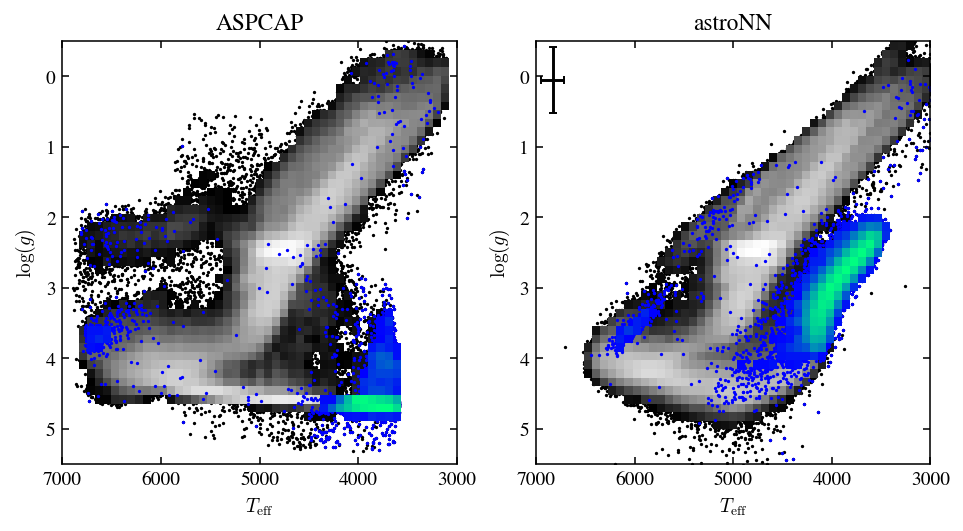

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

xmin, xmax = (3000, 7000)
ymin, ymax = (-0.5, 5.5)
# ASPCAP parameter CMD
ax = axs[0]
scatter_hist(ax, metals['TEFF'], metals['LOGG'], 
             xlim=(xmin, xmax), ylim=(ymin, ymax))
scatter_hist(ax, low_fe['TEFF'], low_fe['LOGG'], 
             xlim=(xmin, xmax), ylim=(ymin, ymax),
             cmap='winter', color='b')
ax.set_xlim((xmax, xmin))
ax.set_ylim((ymax, ymin))
ax.set_xlabel(r'$T_{\rm{eff}}$')
ax.set_ylabel(r'$\log(g)$')
ax.set_title('ASPCAP')

# astroNN parameter CMD
ax = axs[1]
scatter_hist(ax, metals['ASTRONN_TEFF'], metals['ASTRONN_LOGG'], 
             xlim=(xmin, xmax), ylim=(ymin, ymax))
scatter_hist(ax, low_fe['ASTRONN_TEFF'], low_fe['ASTRONN_LOGG'], 
             xlim=(xmin, xmax), ylim=(ymin, ymax),
             cmap='winter', color='b')
plot_rms_err(ax, metals['ASTRONN_TEFF_ERR'], metals['ASTRONN_LOGG_ERR'], loc='lower right')
ax.set_xlim((xmax, xmin))
ax.set_ylim((ymax, ymin))
ax.set_xlabel(r'$T_{\rm{eff}}$')
ax.set_ylabel(r'$\log(g)$')
ax.set_title('astroNN')

plt.show()

### Conclusions about [Fe/H]

This problem is quite straightforward to solve. Because we only care about the stars for which we can measure ages (i.e., subgiants and above), a simple in ASPCAP cut of everything above $\log(g)=4$ removes 95% of the problematic targets. Additional cuts to remove the stragglers could be implemented to get this up to 99%.

In [22]:
# All stars after sanity cuts
print(metals.shape[0])
# All Fe-discrepant stars
print(low_fe.shape[0])
# Simple cut in log(g)
print(low_fe[low_fe['LOGG'] < 4].shape[0])
# Also cut out blue stragglers
print(low_fe[(low_fe['LOGG'] < 4) & (low_fe['TEFF'] < 6000)].shape[0])
# Also cut out bottom right corner
print(low_fe[(low_fe['LOGG'] < 4) & (low_fe['TEFF'] < 6000) & 
             ~((low_fe['LOGG'] > 3) & (low_fe['TEFF'] < 4000))].shape[0])

570101
19784
882
547
177
